# Supplemental Material for EMA Manuscript

Machine learning models for temporally precise lapse prediction in alcohol use disorder

Kendra Wyant, Sarah J. Sant’Ana, Gaylen E. Fronk, John J. Curtin  
December 31, 2024

This file contains the supplemental materials for *Machine learning models for temporally precise lapse prediction in alcohol use disorder*. It includes a transparency report and all supplemental methods, results, and figures. Additional materials are made available on our study’s OSF page (<https://osf.io/w5h9y/>).

In [ ]:
# settings
options(knitr.kable.NA = '')
knitr::opts_chunk$set(out.extra = "")
options(scipen = 999) #removes scientific notation

In [ ]:
library(knitr)
# library(yardstick) # for roc_curve and pr_curve
library(kableExtra)
library(janitor)


Attaching package: 'janitor'

The following objects are masked from 'package:stats':

    chisq.test, fisher.test

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::group_rows() masks kableExtra::group_rows()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──
✔ broom        1.0.7      ✔ rsample      1.2.1 
✔ dials        1.2.1      ✔ tune         1.2.1 
✔ infer        1.0.7      ✔ workflows    1.1.4 
✔ modeldata    1.3.0      ✔ workflowsets 1.1.0 
✔ parsnip      1.2.1      ✔ yardstick    1.3.1 
✔ recipes      1.0.10     
── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard()   masks purrr::discard()
✖ dplyr::filter()     masks stats::filter()
✖ recipes::fixed()    masks stringr::fixed()
✖ dplyr::group_rows() masks kableExtra::group_rows()
✖ dplyr::lag()        masks stats::lag()
✖ yardstick::spec()   masks readr::spec()
✖ recipes::step()     masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/


Attaching package: 'cowplot'

The following object is masked from 'package:lubridate':

    stamp

The following object is masked from 'package:patchwork':

    align_plots

In [ ]:
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/format_path.R?raw=true")

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

In [ ]:
# Table data
disposition <- read_csv(file.path(path_processed, "disposition.csv"), 
                        col_types = "ccDDcccccccccc")
screen <- read_csv(file.path(path_shared, "screen.csv"), 
                   col_types = cols()) |>
  filter(subid %in% subset(disposition, analysis == "yes")$subid)

lapses <- read_csv(file.path(path_shared, "lapses.csv"), col_types = cols()) |>
  filter(exclude == FALSE)

# Predictions data
preds_week<- read_rds(file.path(path_models, "outer_preds_1week_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)
preds_day<- read_rds(file.path(path_models, "outer_preds_1day_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)
preds_hour<- read_rds(file.path(path_models, "outer_preds_1hour_0_v5_nested_main.rds")) |> 
  select(outer_split_num, label, prob = prob_beta)

auc_week <- read_rds(file.path(path_models, "outer_metrics_1week_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))
auc_day <- read_rds(file.path(path_models, "outer_metrics_1day_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))
auc_hour <- read_rds(file.path(path_models, "outer_metrics_1hour_0_v5_nested_main.rds")) |> 
  select(outer_split_num, contains("auc"))

auc_week_baseline <- read_rds(file.path(path_models, "outer_metrics_1week_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc")) 

auc_day_baseline <- read_rds(file.path(path_models, "outer_metrics_1day_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc")) 

auc_hour_baseline <- read_rds(file.path(path_models, "outer_metrics_1hour_0_v3_nested_baseline.rds")) |> 
  select(outer_split_num, contains("auc"))

# posterior probabilities
pp <- read_rds(file.path(path_models, "posteriors_all_0_v5_nested.rds"))
pp_baseline <- read_rds(file.path(path_models, "posteriors_all_0_v3_nested_baseline.rds"))

# roc overall
roc_week_full <- preds_week |> 
  roc_curve(prob, truth = label)

roc_day_full <- preds_day |> 
  roc_curve(prob, truth = label)

roc_hour_full <- preds_hour |> 
  roc_curve(prob, truth = label)

# rocs per fold
roc_week <- preds_week |> 
  nest(.by = outer_split_num, .key = "preds") |> 
  mutate(roc = map(preds, \(preds) roc_curve(preds, prob,
                                             truth = label))) |> 
  mutate(model = "week")

roc_day <- preds_day |> 
  nest(.by = outer_split_num, .key = "preds") |> 
  mutate(roc = map(preds, \(preds) roc_curve(preds, prob,
                                             truth = label))) |> 
  mutate(model = "day")

roc_hour <- preds_hour |> 
  nest(.by = outer_split_num, .key = "preds") |> 
  mutate(roc = map(preds, \(preds) roc_curve(preds, prob,
                                             truth = label))) |> 
  mutate(model = "week")


# PR curves
pr_week <- preds_week |> 
  pr_curve(prob, truth = label) |>  
  mutate(model = "1week")

pr_day <- preds_day |> 
  pr_curve(prob, truth = label) |> 
  mutate(model = "1day")

pr_hour <- preds_hour|> 
  pr_curve(prob, truth = label) |> 
  mutate(model = "1hour")

pr_all <- pr_week |> 
  bind_rows(pr_day) |> 
  bind_rows(pr_hour)

# UPDATE - JJC
# Local and Global Grouped SHAPS
shap_local_week <- read_rds(file.path(path_models, "outer_shapsgrp_1week_0_v5_nested_main.rds")) 
shap_local_day <- read_rds(file.path(path_models, "outer_shapsgrp_1day_0_v5_nested_main.rds"))
shap_local_hour <- read_rds(file.path(path_models, "outer_shapsgrp_1hour_0_v5_nested_main.rds")) 

shap_global_week <- shap_local_week |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(mean_value) |> 
  mutate(model = "Week")
shap_global_day <- shap_local_day |>
  group_by(variable_grp) |> 
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(mean_value) |> 
  mutate(model = "Day")
shap_global_hour <- shap_local_hour |> 
  group_by(variable_grp) |>
  summarize(mean_value = mean(abs(value)), .groups = "drop") |>
  arrange(mean_value) |> 
  mutate(model = "Hour")

shap_global_all <- shap_global_week |> 
  bind_rows(shap_global_day) |> 
  bind_rows(shap_global_hour) |> 
  mutate(model = factor(model, levels = c("Week", "Day", "Hour"))) |> 
  mutate(variable_grp = factor(variable_grp, levels = c("past use (EMA item)", 
                                          "craving (EMA item)", 
                                          "past risky situation (EMA item)", 
                                          "past stressful event (EMA item)", 
                                          "past pleasant event (EMA item)", 
                                          "valence (EMA item)", 
                                          "arousal (EMA item)", 
                                          "future risky situation (EMA item)", 
                                          "future stressful event (EMA item)", 
                                          "future efficacy (EMA item)",
                                          "lapse day (other)",
                                          "lapse hour (other)",
                                          "missing surveys (other)",
                                          "age (demographic)",
                                          "sex (demographic)",
                                          "race (demographic)",
                                          "marital (demographic)",
                                          "education (demographic)")))

# lapse labels
labels_week <- read_csv(file.path(path_processed, "labels_1week.csv"), col_types = cols())
labels_day <- read_csv(file.path(path_processed, "labels_1day.csv"), col_types = cols())
labels_hour <- read_csv(file.path(path_processed, "labels_1hour.csv"), col_types = cols())

# ema data
ema_m <- read_csv(file.path(path_shared, "ema_morning.csv"), col_types = cols()) |> 
  mutate(read_csv = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))
ema_l <- read_csv(file.path(path_shared, "ema_later.csv"), col_types = cols()) |> 
  mutate(start_date = with_tz(start_date, tzone = "America/Chicago"),
         subid = as.numeric(subid))


# features for missing data calculations
d_hour <- read_csv(file.path(path_processed, "features_1hour_0_v5.csv.xz"), col_types = cols())

d_day <- read_csv(file.path(path_processed, "features_1day_0_v5.csv.xz"), col_types = cols())

d_week <- read_csv(file.path(path_processed, "features_1week_0_v5.csv.xz"), col_types = cols())

## Supplemental Figures

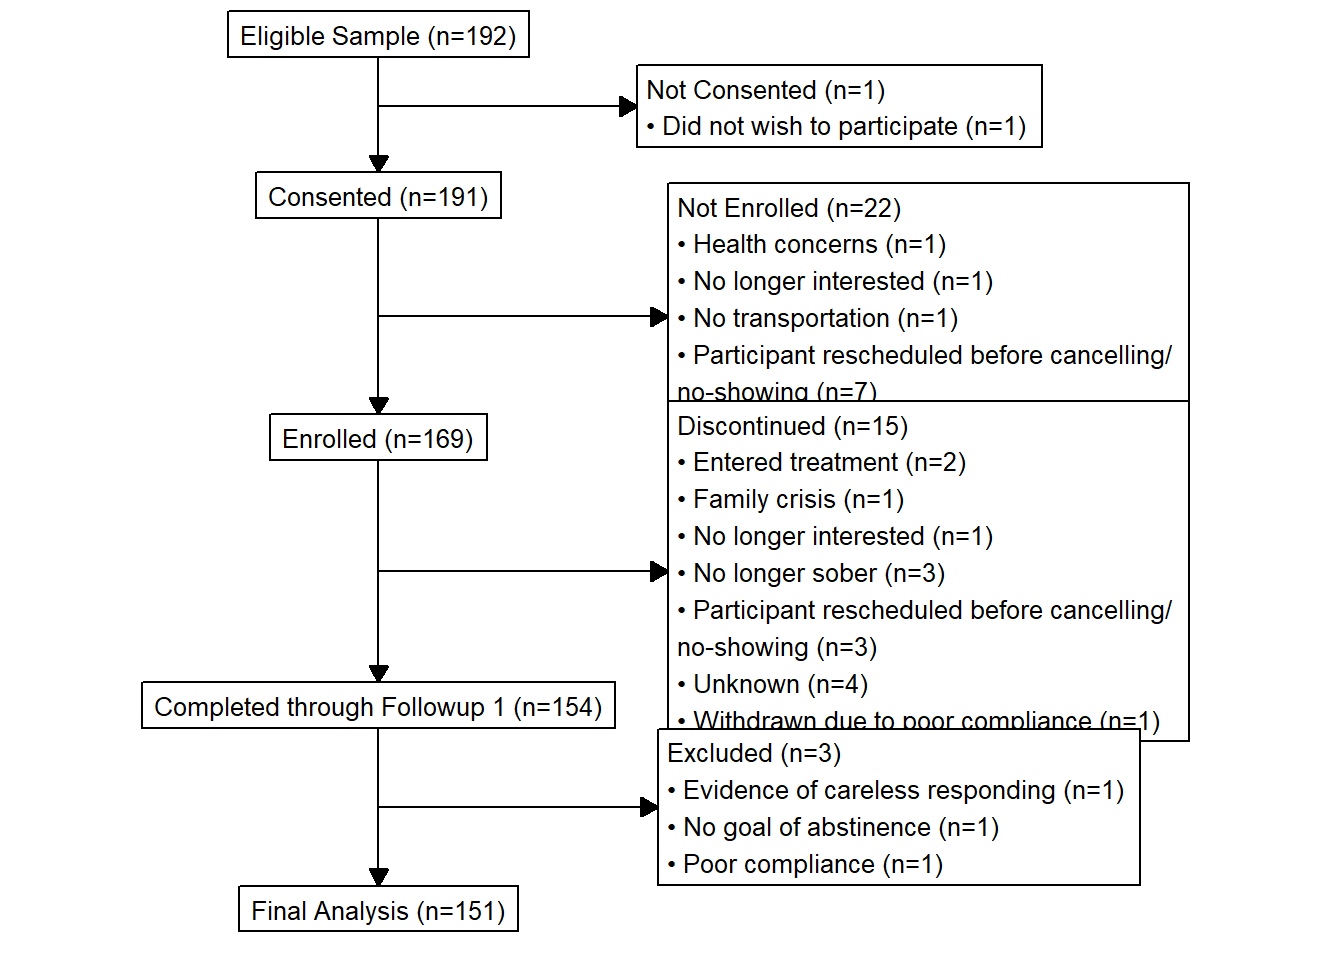

In [ ]:
#| label: fig-consort
#| fig-pos: "hb"
#| fig-cap:
#|   - "CONSORT diagram. The diagram depicts participant retention at each study milestone. It also displays reasons for discontinuation when known and reasons for data exclusions."

consort_plot(data = disposition,
             orders = c(eligible = "Eligible Sample",
                        consented_reason = "Not Consented",
                        consented = "Consented",
                        enrolled_reason = "Not Enrolled",
                        enrolled = "Enrolled",
                        completed_followup_reason = "Discontinued",
                        completed_followup = "Completed through Followup 1",
                        analysis_reason = "Excluded",
                        analysis = "Final Analysis"),
             side_box = c("consented_reason", 
                          "enrolled_reason", 
                          "completed_followup_reason",
                          "analysis_reason"),
             cex = .8,
             text_width = 45)

In [ ]:
ana_sample <- disposition |> 
  filter(analysis == "yes")

ema <- ema_m |> 
  select(subid, start_date) |> 
  full_join(ema_l |> select(subid, start_date), by = c("subid", "start_date")) |> 
  mutate(start_date = date(start_date),
         subid = as.numeric(subid)) |> 
  filter(subid %in% ana_sample$subid)

# function to map over
get_study_days <- function(the_subid, dates) {
  start_study <- dates |> filter(subid == the_subid) |> pull(start_study)
  end_study <- dates |> filter(subid == the_subid) |> pull(end_study)
  study_days <- tibble(subid = the_subid, study_day = seq(start_study, end_study - days(1), by = "day")) 
  return(study_days)
}

study_dates <- ana_sample$subid |> 
  map_dfr(~get_study_days(.x, disposition |> 
                            select(subid, start_study, end_study)))

# count EMAs per day
ema_count_4x <- ema |>  
  count(subid, start_date) |>
  mutate(n = if_else(n > 4, 4, as.numeric(n)))

# left join with study dates
ema_study_dates <- study_dates |>
  left_join(ema_count_4x |> 
              mutate(subid = as.character(subid)), by = c("subid", "study_day" = "start_date")) |> 
  mutate(n = if_else(is.na(n), 0, n)) |> 
  mutate(n_prompts = 4)

# slice into 7 day bins
ema_study_weeks <- ema_study_dates |> 
  group_by(subid) |> 
  slice(1:7) |> 
  mutate(week = 1) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(8:14) |> 
    mutate(week = 2)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(15:21) |> 
    mutate(week = 3)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(22:28) |> 
    mutate(week = 4)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(29:35) |> 
    mutate(week = 5)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(36:42) |> 
    mutate(week = 6)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(43:49) |> 
    mutate(week = 7)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(50:56) |> 
    mutate(week = 8)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(57:63) |> 
    mutate(week = 9)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(64:70) |> 
    mutate(week = 10)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(71:77) |> 
    mutate(week = 11)) |> 
  bind_rows(ema_study_dates |> 
    group_by(subid) |> 
    slice(78:84) |> 
    mutate(week = 12)) |> 
  ungroup()

ema_week_compliance_4x <- ema_study_weeks |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

ema_week_compliance_1x <- ema_study_weeks |>
  mutate(n = if_else(n > 1, 1, n),
         n_prompts = 1) |> 
  group_by(subid, week) |> 
  summarize(sum_n = sum(n), sum_prompts = sum(n_prompts), .groups = "rowwise") |> 
  mutate(compliance = sum_n/sum_prompts) |> 
  ungroup()

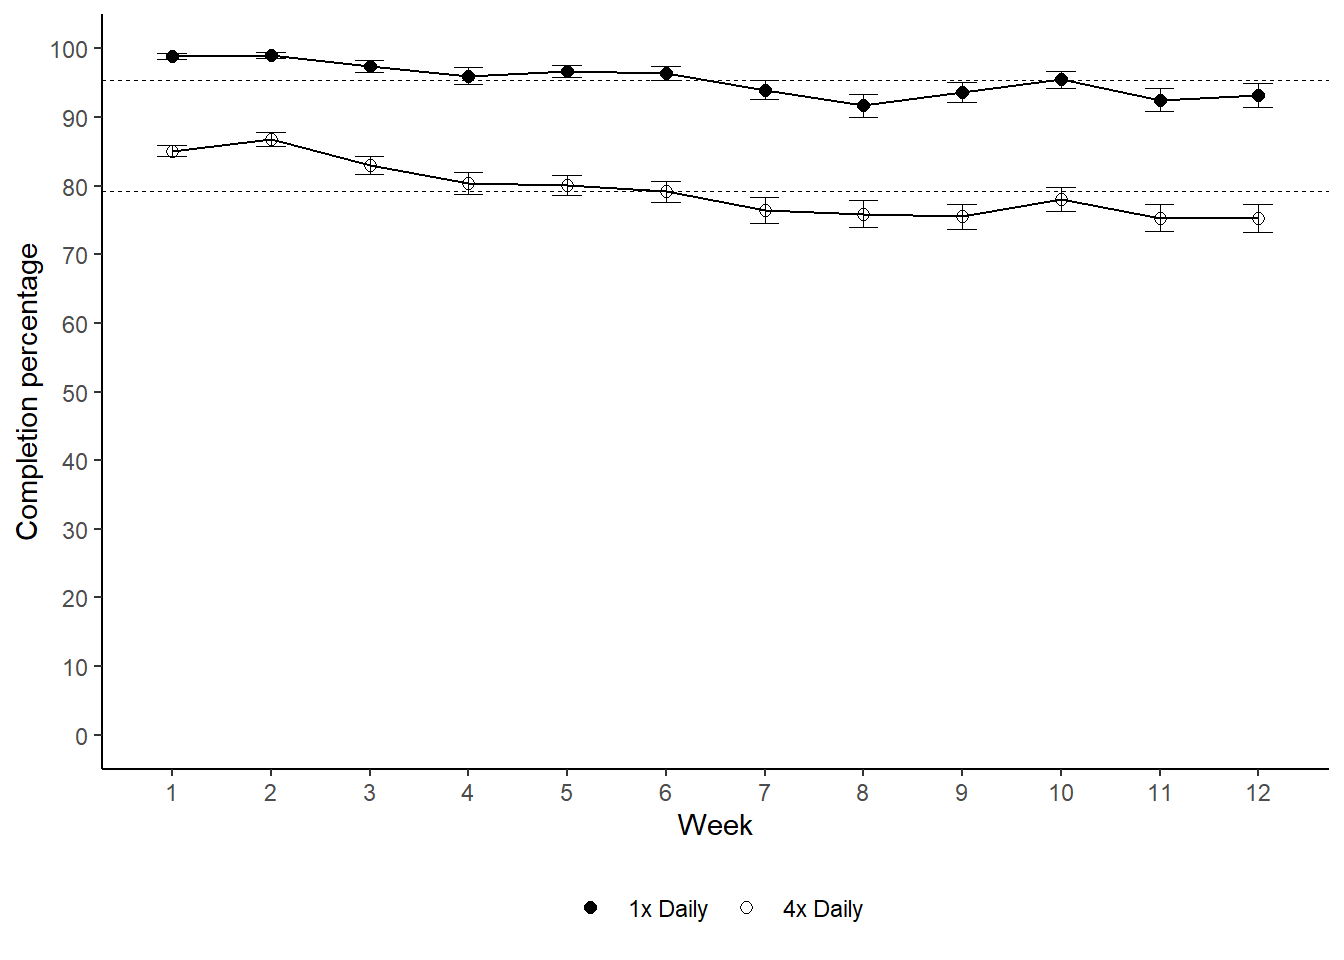

In [ ]:
#| label: fig-ema-1x
#| fig-cap:
#|   - "EMA completion by week. The plot depicts completion percentages over time (by week) across the study period for 1x (closed circles) and 4x (open circles) daily EMA. Dashed lines represent mean EMA completion over entire study period for 1x and 4x daily EMA. Error bars represent the standard error for each completion percentage by week."

week_compliance_all <- ema_week_compliance_4x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "4x Daily") |> 
  bind_rows(ema_week_compliance_1x |> 
              mutate(compliance = compliance*100) |> 
              group_by(week) |> 
              summarize(mean_compliance = mean(compliance),
                        n = n(),
                        sd = sd(compliance)) |> 
              mutate(se = sd/sqrt(n),
                     signal = "1x Daily")) 


week_compliance_all |> 
  mutate(signal = factor(signal, levels = c("1x Daily", "4x Daily"))) |> 
  group_by(week, signal) |> 
  ggplot(aes(x = week, y = mean_compliance, group = signal, shape = signal)) +
  geom_point(size = 2) +
  geom_line() +
  geom_errorbar(aes(ymin = mean_compliance - se, ymax = mean_compliance + se), 
                width = .3, linewidth = .3) +
  theme_classic() +
  scale_shape_manual(values = c(19, 1, 17)) +
  scale_x_continuous(name = "Week", 
                     breaks = seq(1, 12, 1)) +
  scale_y_continuous(name = "Completion percentage", 
                     breaks = seq(0, 100, 10), 
                     limits = c(0, 100)) +
  geom_hline(aes(yintercept = mean_compliance), week_compliance_all |> 
               group_by(signal) |> 
               summarize(mean_compliance = mean(mean_compliance)),
             linetype = "dashed", linewidth = .3) +
  theme(legend.title = element_blank(),
        legend.position = "bottom")

In [ ]:
build_recipe <- function(d) {
  # d: (training) dataset from which to build recipe

  rec <- recipe(y ~ ., data = d) |>
    step_rm(subid) |> 
    step_dummy(all_nominal_predictors()) 
  
  return(rec)
}

format_data <- function (df){
  
  df |> 
    rename(y = "lapse") |> 
    mutate(y = factor(y, levels = c("yes", "no")), # set pos class first
           across(where(is.character), factor)) |>
    select(-label_num, -dttm_label)
 }

In [ ]:
# week
d_week <- d_week |> 
  format_data()
rec <- build_recipe(d = d_week)
feat_week <- rec |>  
  prep(training = d_week, strings_as_factors = FALSE) |>
  bake(new_data = d_week)  |> 
  select(-y) 

# day
d_day <- d_day |> 
  format_data()
rec <- build_recipe(d = d_day)
feat_day <- rec |>  
  prep(training = d_day, strings_as_factors = FALSE) |>
  bake(new_data = d_day)  |> 
  select(-y) 

# hour
d_hour <- d_hour |> 
  format_data()
rec <- build_recipe(d = d_hour)
feat_hour <- rec |>  
  prep(training = d_hour, strings_as_factors = FALSE) |>
  bake(new_data = d_hour)  |> 
  select(-y) 

feat_all <- feat_week |> 
  mutate(width = "week") |> 
  rbind(feat_day |> 
  mutate(width = "day")) |> 
  rbind(feat_hour |> 
  mutate(width = "hour")) |> 
  mutate(width = factor(width, levels = c("week", "day", "hour"),
                        labels = c("Week", "Day", "Hour")))

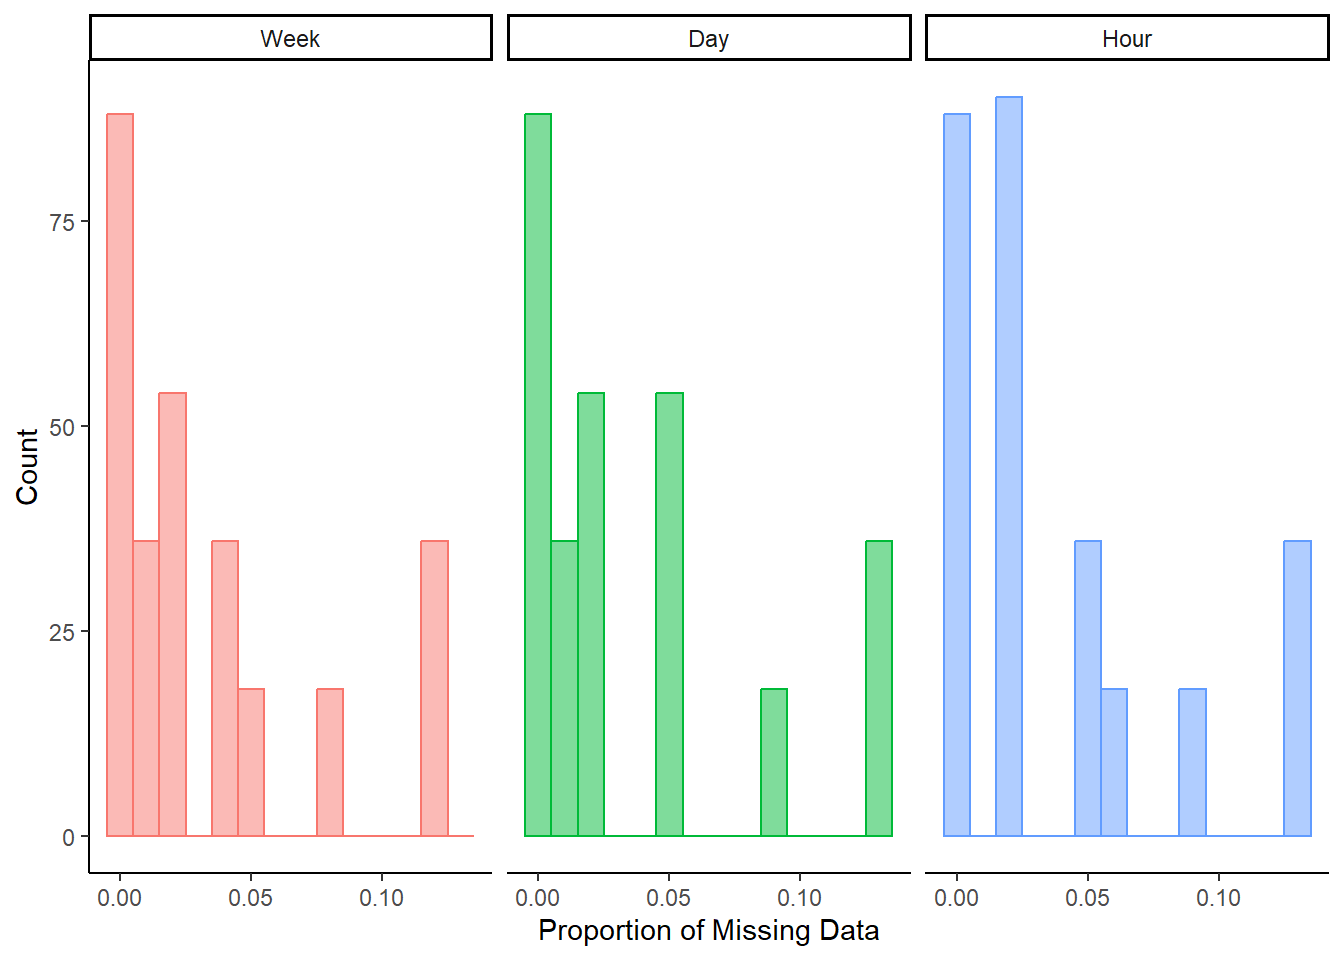

In [ ]:
#| label: fig-missing
#| fig-cap:
#|   - "Histogram of proportion of missing data by model. The plot depicts histograms of the proportion of missing data across the 268 features for each full model (Week, Day, and Hour)."

feat_all |> 
  group_by(width) |> 
  summarize(across(everything(), ~mean(is.na(.x)))) |> 
  pivot_longer(cols = c(everything(), -width),
               names_to = "feature", values_to = "pct_miss") |> 
  ggplot(aes(x = pct_miss, color = width, fill = width)) +
  geom_histogram(alpha = .5, binwidth = .01) +
  facet_wrap("width") +
  theme(legend.position = "none") +
  xlab("Proportion of Missing Data") +
  ylab("Count")

In [ ]:
fig_roc_week <- roc_week_full |> 
  ggplot(aes(x = 1 - specificity, y = sensitivity)) + 
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "Specificity",
       y = "Sensitivity") +
  scale_x_continuous(breaks = seq(0,1,.25),
    labels = sprintf("%.2f", seq(1,0,-.25))) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
  
for (i in 1:nrow(roc_week)) {
  fig_roc_week <- fig_roc_week +
     geom_path(data = roc_week$roc[[i]],
               mapping = aes(x = 1 - specificity, y = sensitivity),
               color = "#fdd2ce")
}

fig_roc_week <- fig_roc_week +
     geom_path(data = roc_week_full,
               mapping = aes(x = 1 - specificity, y = sensitivity),
               color = "#F8766D", linewidth = 1)

In [ ]:
fig_roc_day <- roc_day_full |> 
  ggplot(aes(x = 1 - specificity, y = sensitivity)) + 
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "Specificity",
       y = "Sensitivity") +
  scale_x_continuous(breaks = seq(0,1,.25),
    labels = sprintf("%.2f", seq(1,0,-.25))) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) 
  
for (i in 1:nrow(roc_day)) {
  fig_roc_day <- fig_roc_day +
     geom_path(data = roc_day$roc[[i]],
               mapping = aes(x = 1 - specificity, y = sensitivity),
               color = "#bcffcf")
}

fig_roc_day <- fig_roc_day +
     geom_path(data = roc_day_full,
               mapping = aes(x = 1 - specificity, y = sensitivity),
               color = "#00BA38", linewidth = 1)

In [ ]:
fig_roc_hour <- roc_hour_full |> 
  ggplot(aes(x = 1 - specificity, y = sensitivity)) + 
  geom_abline(lty = 3) +
  coord_fixed(xlim = c(0, 1), ylim = c(0, 1)) +
  labs(x = "Specificity",
       y = "Sensitivity") +
  scale_x_continuous(breaks = seq(0,1,.25),
    labels = sprintf("%.2f", seq(1,0,-.25))) 
  
for (i in 1:nrow(roc_hour)) {
  fig_roc_hour <- fig_roc_hour +
     geom_path(data = roc_hour$roc[[i]],
               mapping = aes(x = 1 - specificity, y = sensitivity),
               color = "#c8dcff")
}

fig_roc_hour <- fig_roc_hour +
     geom_path(data = roc_week_full,
               mapping = aes(x = 1 - specificity, y = sensitivity),
               color = "#619CFF", linewidth = 1)

In [ ]:
fig_auc_week <- auc_week |> 
  mutate(model = "Week") |>
  ggplot() + 
  geom_histogram(aes(x = roc_auc), fill = "#F8766D", color = "black", alpha = .4, bins = 15) +
  facet_wrap(~model, ncol = 1, strip.position = "right") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "none") +
  ylab("Count")

fig_auc_day <- auc_day |> 
  mutate(model = "Day") |>
  ggplot() + 
  geom_histogram(aes(x = roc_auc), fill = "#00BA38", color = "black", alpha = .4, bins = 15) +
  facet_wrap(~model, ncol = 1, strip.position = "right") +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        legend.position = "none") +
  ylab("Count")

fig_auc_hour <- auc_hour |> 
  mutate(model = "Hour") |> 
  ggplot() + 
  geom_histogram(aes(x = roc_auc), fill = "#619CFF", color = "black", alpha = .4, bins = 15) +
  facet_wrap(~model, ncol = 1, strip.position = "right") +
  xlab("Area Under ROC Curve (per fold)") +
  ylab("Count")

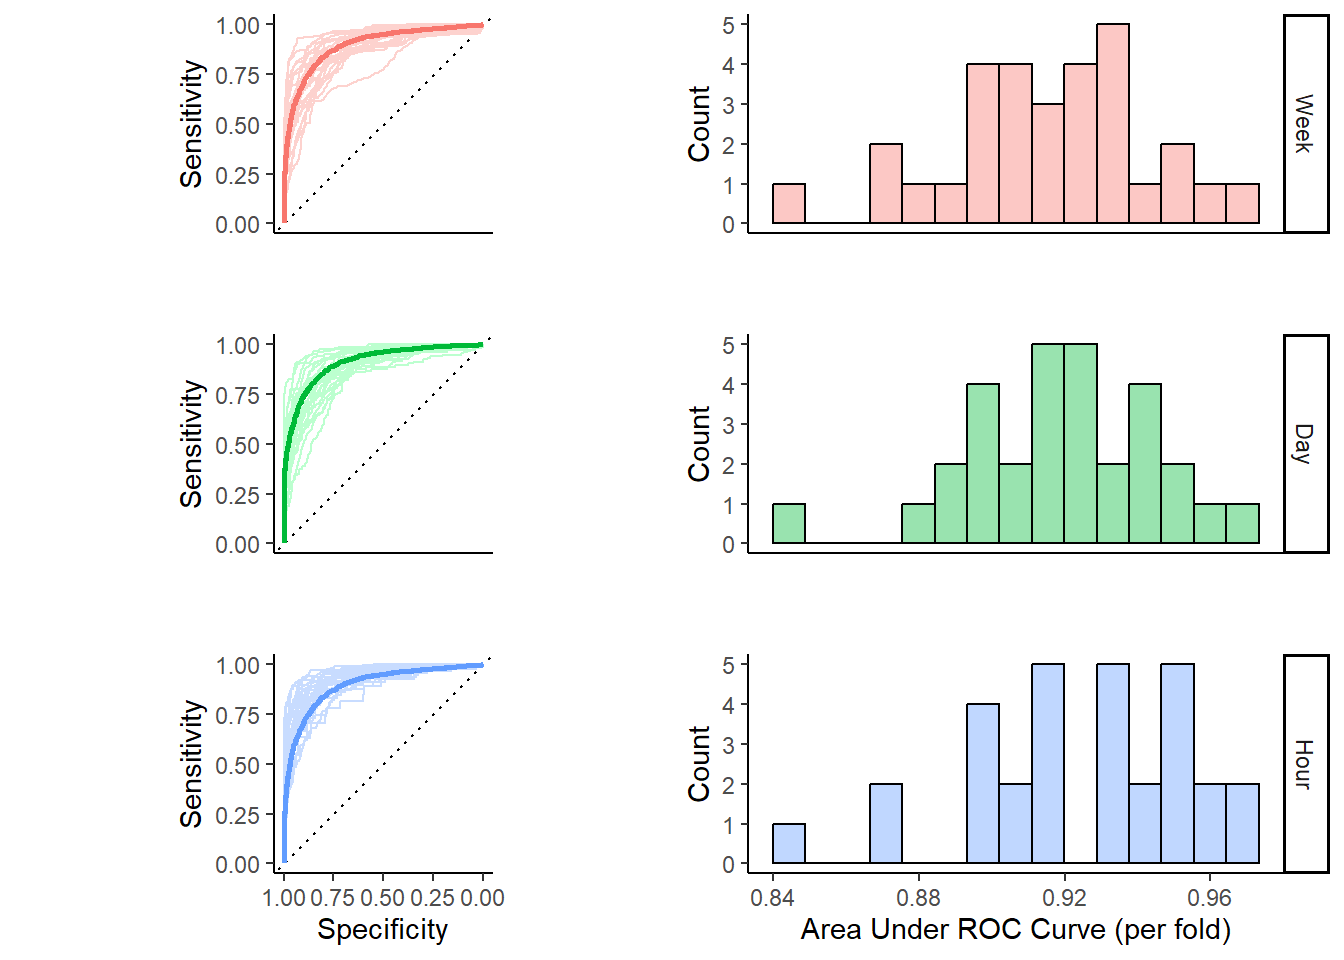

In [ ]:
#| label: fig-roc-auc
#| fig-cap:
#|   - "ROC curves and auROCs by model. The plots on the left depict individual receiver operating characteristic (ROC) curves from each of the 30 test sets. The darker curves represent the aggregate ROC curve derived by concatenating all held out folds. The dotted line represents the expected ROC curve for a random classifier. The histograms on the right depict the distribution of areas under the ROC curves (auROCs) from the same 30 test sets. The rows are organized by model (week, day, hour)."

plot_grid(fig_roc_week, fig_auc_week, fig_roc_day, fig_auc_day, fig_roc_hour, fig_auc_hour,
          ncol = 2, align = "h")

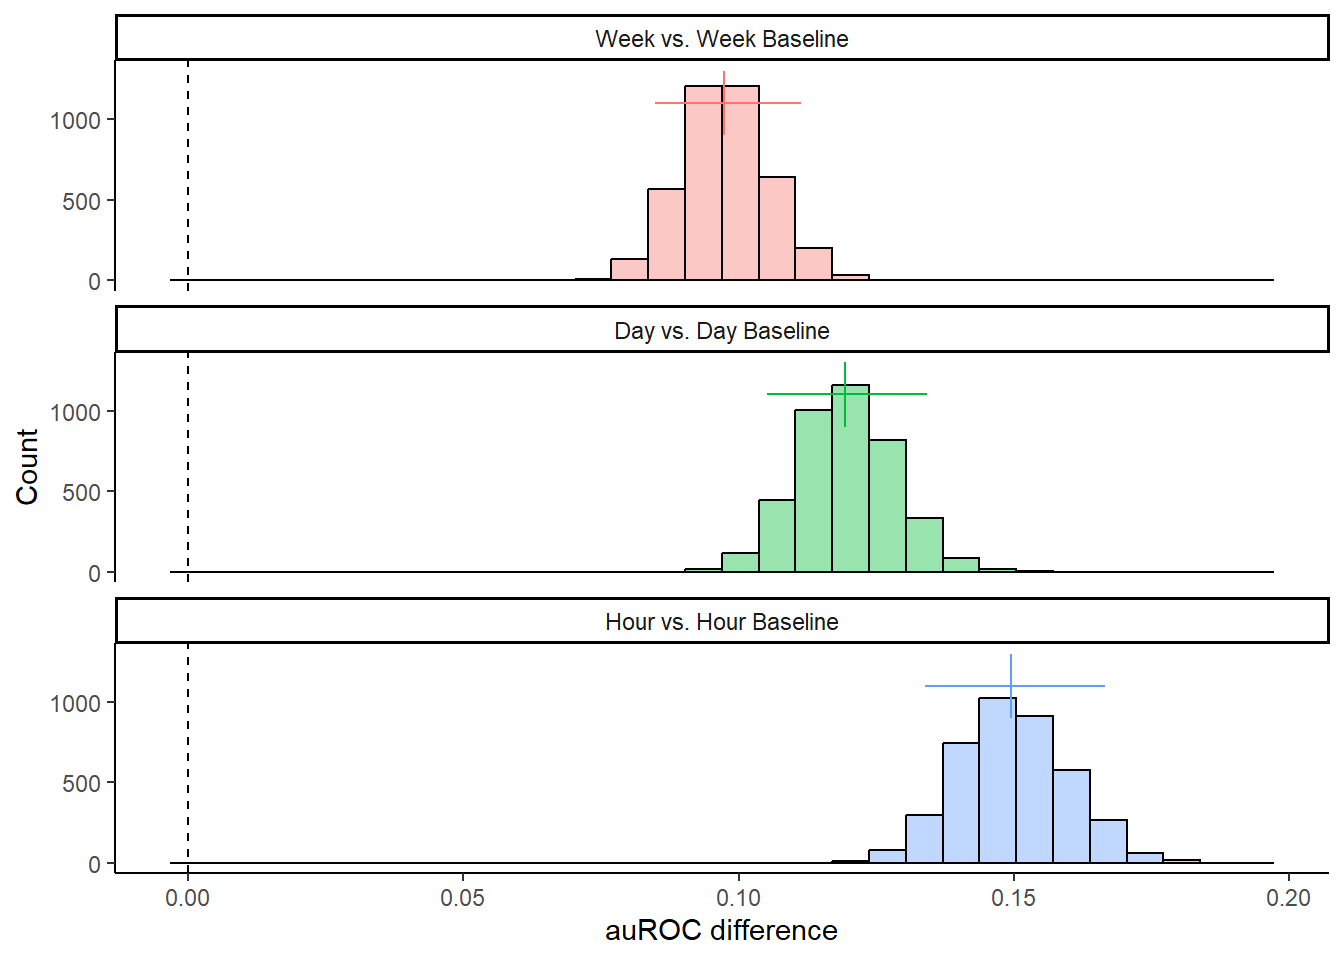

In [ ]:
#| label: fig-contrast
#| fig-cap:
#|   - "Bayesian Contrasts for Full vs. Baseline Models. The plots above depict the posterior probabilities for the areas under the receiver operating characteristic curves (auROCs) of our Baseline vs. Full model contrasts (i.e., the difference in auROC between the models). Each row represents a model constrast (Full vs. Baseline week, Full vs. Baseline day, Full vs. Baseline hour). The solid vertical lines represent the median posterior probability. The horizontal lines represent the 95% CI. The dashed vertical lines indicate an auROC model difference of 0 which denotes no difference in performance."
ci_baseline <- contrast_models(pp_baseline, 
                  list("hour","day", "week"), 
                  list("hour_baseline", "day_baseline", "week_baseline")) |> 
  summary(size = .01) |> 
  mutate(contrast = factor(contrast,
                           levels = c("week vs week_baseline",
                                      "day vs day_baseline",
                                      "hour vs hour_baseline"),
                           labels = c("Week vs. Week Baseline",
                                      "Day vs. Day Baseline",
                                      "Hour vs. Hour Baseline")),
         y = 700)

ci_median_baseline <- pp_baseline |> 
  contrast_models(list("week","day", "hour"), 
                list("week_baseline", "day_baseline", "hour_baseline")) |> 
  group_by(contrast) |> 
  summarize(median = quantile(difference, .5)) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("week vs. week_baseline", "day vs. day_baseline", 
                                      "hour vs. hour_baseline"),
                           labels = c("Week vs. Week Baseline",
                                      "Day vs. Day Baseline",
                                      "Hour vs. Hour Baseline")))

ci_baseline <- ci_baseline |> 
  left_join(ci_median_baseline, by = c("contrast")) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("Week vs. Week Baseline",
                                      "Day vs. Day Baseline",
                                      "Hour vs. Hour Baseline")))

pp_baseline |>
  tidy(seed = 123) |>
  group_by(model) |>
  mutate(sample = row_number()) |>
  ungroup() |>
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(hour_vs_hour_baseline = hour - hour_baseline,
         day_vs_day_baseline = day - day_baseline,
         week_vs_week_baseline = week - week_baseline) |>
  pivot_longer(cols = hour_vs_hour_baseline:week_vs_week_baseline,
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast,
                           levels = c("week_vs_week_baseline",
                                      "day_vs_day_baseline",
                                      "hour_vs_hour_baseline"),
                           labels = c("Week vs. Week Baseline",
                                      "Day vs. Day Baseline",
                                      "Hour vs. Hour Baseline"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior, fill = contrast), 
                 color = "black",  alpha = .4, bins = 30, show.legend = FALSE) +
  geom_vline(xintercept = 0, color = "black", linetype = "dashed") +
  geom_segment(mapping = aes(y = y+600, yend = y+200, x = median, xend = median,
                             color = contrast),
               data = ci_baseline, show.legend = FALSE) +
  geom_segment(mapping = aes(y = y+400, yend = y+400, x = lower, xend = upper, color = contrast), 
               data = ci_baseline, show.legend = FALSE) +
  facet_wrap(~contrast, ncol = 1) +
  xlab("auROC difference") +
  ylab("Count") 

In [ ]:
#| output: true
#| fig-cap:
#|   - "Bayesian model contrasts. The plots above depict the posterior probabilities for the areas under the receiver operating characteristic curves (auROCs) of our model contrasts (i.e., the difference in auROC between the two models). Each row represents a model constrast (hour vs. week, hour vs. day, day vs. week). The solid vertical lines represent the median posterior probability. The horizontal lines represent the 95% CI. The dashed vertical lines indicate an auROC model difference of 0 which denotes no difference in performance."

ci <- pp |> 
  contrast_models(list("hour","hour", "day"), 
                list("week", "day", "week")) |> 
  summary(size = .01) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("hour vs week", "hour vs day", "day vs week"),
                           labels = c("Hour vs. Week", "Hour vs. Day", "Day vs. Week")),
         y = 700)


ci_median <- pp |> 
  contrast_models(list("hour","hour", "day"), 
                list("week", "day", "week")) |> 
  group_by(contrast) |> 
  summarize(median = quantile(difference, .5),
            mean = mean(difference)) |> 
  mutate(contrast = factor(contrast, 
                           levels = c("hour vs. week", "hour vs. day", "day vs. week"),
                           labels = c("Hour vs. Week", "Hour vs. Day", "Day vs. Week")))

ci <- ci |> 
  left_join(ci_median, by = c("contrast", "mean"))


pp |> 
  tidy(seed = 123) |>   
  group_by(model) |> 
  mutate(sample = row_number()) |> 
  ungroup() |> 
  pivot_wider(names_from = model, values_from = posterior) |> 
  mutate(hour_vs_week = hour - week,
         hour_vs_day = hour - day,
         day_vs_week = day - week) |> 
  pivot_longer(cols = hour_vs_week:day_vs_week,
               names_to = "contrast",
               values_to = "posterior") |> 
  mutate(contrast = factor(contrast, 
                           levels = c("hour_vs_week", "hour_vs_day", "day_vs_week"),
                           labels = c("Hour vs. Week", "Hour vs. Day", "Day vs. Week"))) |> 
  ggplot() +
  geom_histogram(aes(x = posterior), 
                 color = "black", fill = "grey", alpha = .4, bins = 30) +
  geom_vline(xintercept = 0, color = "black", linetype = "dashed") +
  geom_segment(mapping = aes(y = y+100, yend = y-100, x = median, xend = median), 
               data = ci, show.legend = FALSE) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper), 
               data = ci, show.legend = FALSE) +
  # geom_text(data = ci, x = c(.0255, .043, .018), y = 700, 
  #           label = str_c(round(ci$mean, 2), " [", round(ci$lower, 2), ", ", round(ci$upper, 2), "]")) +
  facet_wrap(~contrast, ncol = 1) +
  xlab("auROC difference") +
  ylab("Count")

In [ ]:
j_thres_week <- roc_week_full |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
#  print() |> 
  pull(.threshold)

j_thres_day <- roc_day_full |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
#  print() |> 
  pull(.threshold)

j_thres_hour <- roc_hour_full |> 
  mutate(j = sensitivity + specificity - 1) |> 
  slice_max(j) |> 
#  print() |> 
  pull(.threshold)

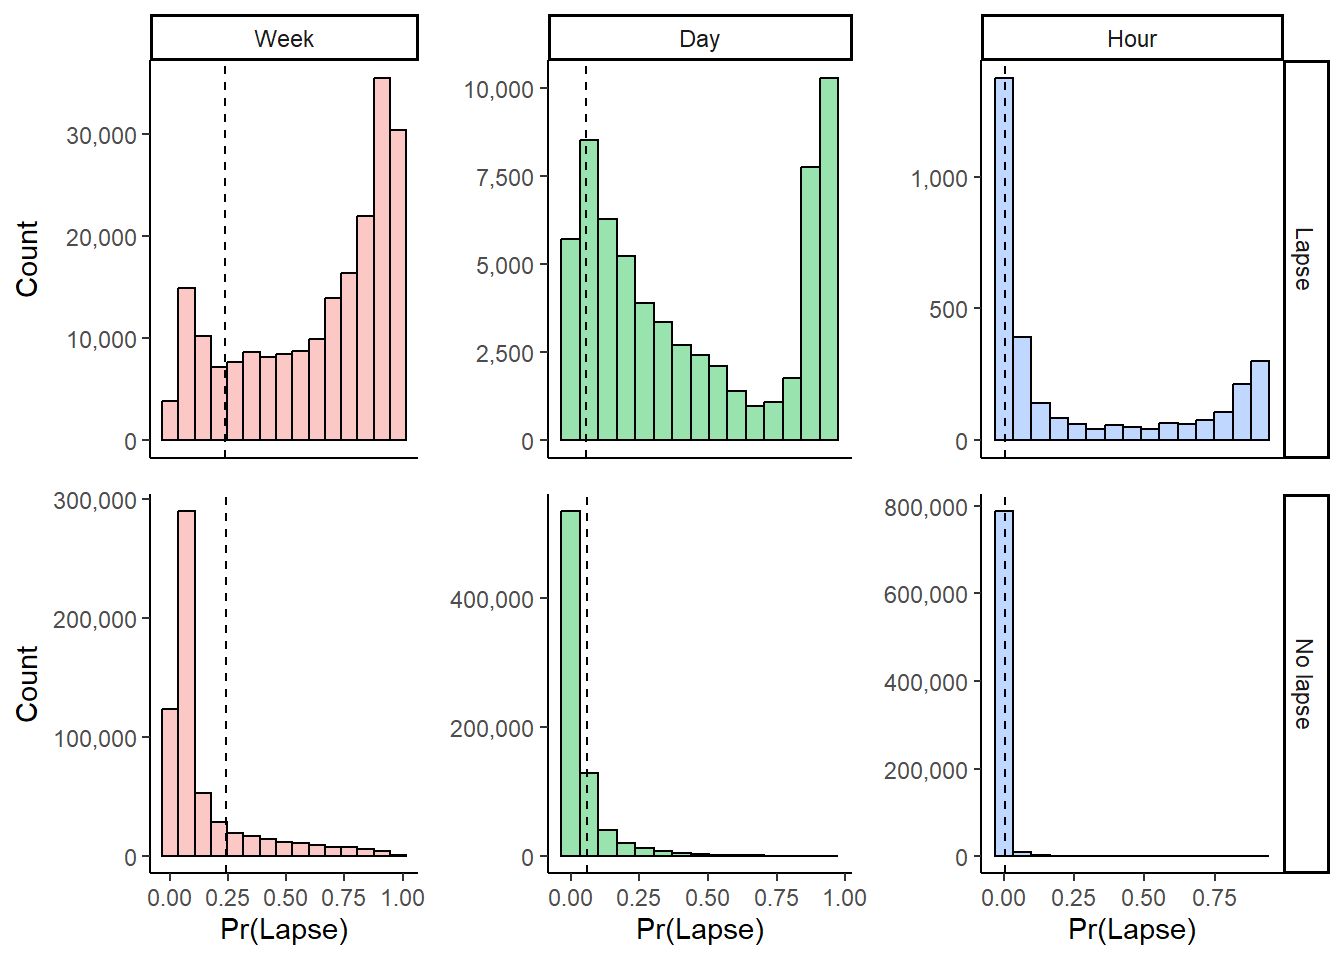

In [ ]:
#| label: fig-preds
#| fig-cap:
#|   - "Lapse probability predictions by model. The plots above depict predicted probabilities for all observations in the 30 test sets. The columns are organized by model (week, day, hour). The top row depicts estimated lapse probabilities for true lapses. The bottom row depicts estimated lapse probabilities for true no lapses. The dashed vertical lines represent the decision threshold for each model, determined using Youden's index."

fig_preds_week_lapse <- preds_week |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Week") |> 
  filter(truth == "Lapse") |> 
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#F8766D", col = "black", alpha = .4) +
   facet_wrap(~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_week, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab("Count")

fig_preds_week_nolapse <- preds_week |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Week") |> 
  filter(truth == "No lapse") |> 
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#F8766D", col = "black", alpha = .4) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_week, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab("Count")


fig_preds_day_lapse <- preds_day |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Day") |> 
  filter(truth == "Lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#00BA38", col = "black", alpha = .4) +
   facet_wrap(~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_day, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab(NULL)

fig_preds_day_nolapse <- preds_day |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Day") |> 
  filter(truth == "No lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#00BA38", col = "black", alpha = .4) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_day, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab(NULL)

fig_preds_hour_lapse <- preds_hour |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Hour") |> 
  filter(truth == "Lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#619CFF", col = "black", alpha = .4) +
   facet_grid(truth~model) +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_hour, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank()) +
  ylab(NULL)

fig_preds_hour_nolapse <- preds_hour |> 
  rename(truth = label) |> 
  mutate(estimate = if_else(prob < .5, "No lapse", "Lapse"),
         model = "Hour") |> 
  filter(truth == "No lapse") |>
  ggplot(aes(x = prob)) + 
   geom_histogram(bins = 15, fill = "#619CFF", col = "black", alpha = .4) +
   facet_wrap(~truth, strip.position = "right") +
   xlab("Pr(Lapse)") +
  geom_vline(xintercept = j_thres_hour, linetype = "dashed") +
  scale_y_continuous(labels = scales::comma) +
  ylab(NULL)


fig_week <- plot_grid(fig_preds_week_lapse, fig_preds_week_nolapse, ncol = 1, align = "v")
fig_day <- plot_grid(fig_preds_day_lapse, fig_preds_day_nolapse, ncol = 1, align = "v")
fig_hour <- plot_grid(fig_preds_hour_lapse, fig_preds_hour_nolapse, ncol = 1, align = "v")


plot_grid(fig_week, fig_day, fig_hour, nrow = 1, rel_widths = c(1, 1, 1.1))